# Notebook : NLP pour l’analyse de critiques de films

*David Scanu et Ramata Soraya Dussart*

Dans ce brief, il est question d'analyser le sentiment à travers des critiques en français de spectateurs sur des films.

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Importer le .csv

In [168]:
# Import CSV du corpus
df_from_csv = pd.read_csv('corpus.csv', sep='|')
df_from_csv.shape

(7365, 2)

In [169]:
df_from_csv.columns

Index(['note', 'comment'], dtype='object')

In [170]:
df_from_csv.head()

,note,comment
0,5.0,Après le chef d'oeuvre super-héroïque The Dark...
1,5.0,C’est fou ce qu’on aime détester Christopher N...
2,5.0,CHEF D’ŒUVRE ! Le film est absolument parfait ...
3,5.0,"Un film aussi novateur que complexe, dont la m..."
4,5.0,Christopher Nolan est sûrement l'un des seuls ...


## Encoder les notes (cible) en 1 et 0

Jusque là, à chaque commentaire est associé une note de 1 à 5 et non une classe binaire. Il nous faut donc **convertir nos notes en : 1 pour avis positif et 0 : pour avis négatif**. Positif si > 3.

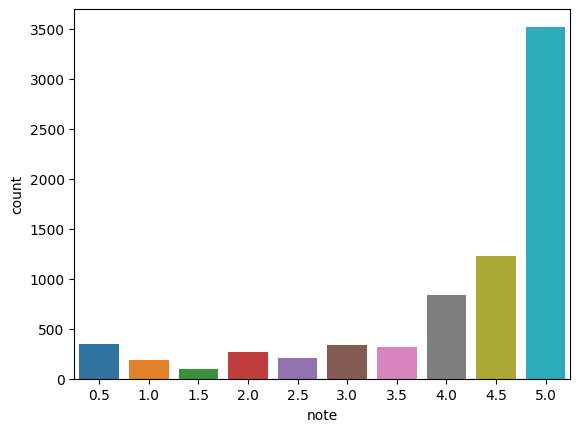

In [171]:
sns.countplot(data=df_from_csv, x=df_from_csv.note)
plt.show()

In [172]:
df_from_csv.loc[(df_from_csv.note <= 3), 'note'] = 0 # Avis négatifs
df_from_csv.loc[(df_from_csv.note > 3), 'note'] = 1 # Avis positifs
print(df_from_csv.note.value_counts())

1.0    5911
0.0    1454
Name: note, dtype: int64


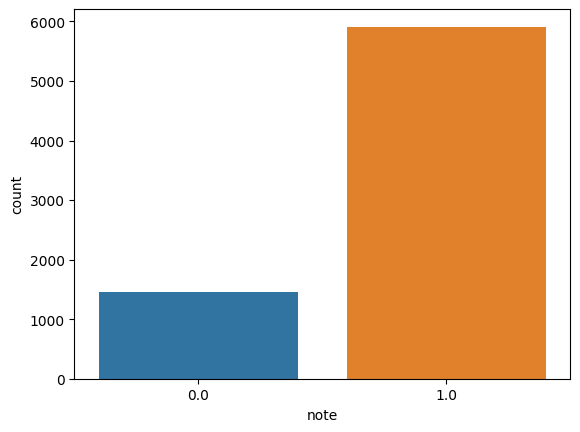

In [173]:
sns.countplot(data=df_from_csv, x=df_from_csv['note'])
plt.show()

## Suppression des NaN

In [174]:
# Compter les NaN dans le DF
df_from_csv.isna().sum().sum()

1

In [175]:
df_from_csv.dropna(inplace=True)

## Suppression des commentaires trop courts

In [176]:
df_from_csv.shape

(7364, 2)

In [177]:
# Affiche tous les commentaires inférieur à 20 caractères
df_from_csv.loc[(df_from_csv.comment.str.len() < 20), 'comment']

435               très bien
668     Excellent film !!!!
854          Exceptionnel !
920         Cultissime....!
1262              Super??!!
               ...         
6959             Magnifique
6968     Très très bon film
7016       Un peu complexe.
7021     Je ve voir ce film
7106        Tros compliquer
Name: comment, Length: 84, dtype: object

In [178]:
# Supprime tous les commentaires inférieur à 20 caractères
df_from_csv.drop(df_from_csv.loc[(df_from_csv.comment.str.len() < 20), 'comment'].index, inplace=True)

In [179]:
df_from_csv.shape

(7280, 2)

## Suppression d'avis positifs

Il y a beaucoup plus d'avis positifs (5841) que d'avis négatifs (1439). Afin d'avoir des données d'entrainement équilibrées, nous décidons de supprimer des avis positifs.

In [180]:
print(df_from_csv.note.value_counts())

1.0    5841
0.0    1439
Name: note, dtype: int64


In [181]:
df_from_csv.drop(df_from_csv[(df_from_csv.note == 1) & (df_from_csv.index > 3000)].index, inplace=True)

print(df_from_csv.note.value_counts())


1.0    2342
0.0    1439
Name: note, dtype: int64


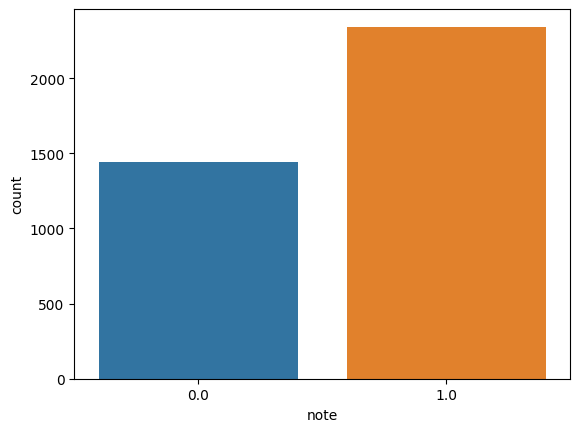

In [182]:
sns.countplot(data=df_from_csv, x=df_from_csv['note'])
plt.show()

## Préparation entrées / sorties

In [183]:
X = df_from_csv['comment']
y = df_from_csv['note']

In [184]:
X.head()

0    Après le chef d'oeuvre super-héroïque The Dark...
1    C’est fou ce qu’on aime détester Christopher N...
2    CHEF D’ŒUVRE ! Le film est absolument parfait ...
3    Un film aussi novateur que complexe, dont la m...
4    Christopher Nolan est sûrement l'un des seuls ...
Name: comment, dtype: object

In [185]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: note, dtype: float64

## Train Test Split

In [186]:
from sklearn.model_selection import train_test_split

# Split les données, retourne DataFrame ou ndarray
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

print(f"Nombre d'exemples d'entrainement X : {X_train.shape[0]}")
print(f"Nombre d'exemples de test X : {X_test.shape[0]}")
print(' ')
print(f"Nombre d'exemples d'entrainement y : {y_train.shape[0]}")
print(f"Nombre d'exemples de test y : {y_test.shape[0]}")

Nombre d'exemples d'entrainement X : 3024
Nombre d'exemples de test X : 757
 
Nombre d'exemples d'entrainement y : 3024
Nombre d'exemples de test y : 757


## Text Augmentation

### Back Translation

In [187]:
# Back Translation
from googletrans import Translator
# googletrans            3.1.0a0

def back_translate(sequence, language):
    translator = Translator()
    #translate to new language and back to original
    translated = translator.translate(sequence, dest = language).text
    #translate back to original language
    translated_back = translator.translate(translated, dest = 'fr').text
    return translated_back

def generate_comments(X, y, y_value, count, language):
    for comment in X[y == y_value]:
        while count > 0:
            output_translate = back_translate(comment, language)
            # check if back translated comment is different from original comment
            if comment != output_translate :
                # print("Original : ", comment)
                # print("Back Translated : ", output_translate)
                # print()
                X = pd.concat([X, pd.Series(output_translate)]) # ignore_index=True
                y = pd.concat([y, pd.Series(y_value)])
                count-=1
    return X, y

In [188]:
y_train.value_counts()

1.0    1852
0.0    1172
Name: note, dtype: int64

In [189]:
X_train, y_train = generate_comments(X_train, y_train, 0, 680, "en")

In [192]:
y_train.value_counts()

0.0    1852
1.0    1852
dtype: int64

## Nettoyage des commentaires

In [193]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

def clean_text(text):

    # Standardize text
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")

    # Lower Casing
    text = text.lower()

    # accents ?

    # Tokenization
    words = nltk.word_tokenize(text) # list

    # Remove punctuation
    new_words = [word for word in words if word.isalnum()]

    # Stop Word Removal
    WordSet = []
    for word in new_words:
        if word not in set(stopwords.words("french")):
            WordSet.append(word)
    
    # Lemmatization
    # lm = FrenchLefffLemmatizer()
    # # lm= WordNetLemmatizer()
    # WordSetLem = []
    # for word in WordSet:
    #     WordSetLem.append(lm.lemmatize(word))

    return ' '.join(WordSet) # return string for CountVectorizer

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/david/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [194]:
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [195]:
X_train_clean.head()

4815    concept départ génial créer structure rêves in...
822     claque 2010 film demande encore comment certai...
457     film incontestablement chef incapacité dire cr...
1974    grand film beaucoup suspense rebondissements s...
2550    inception nouveau film chris nolan nouveau fil...
dtype: object

## Word Clouds

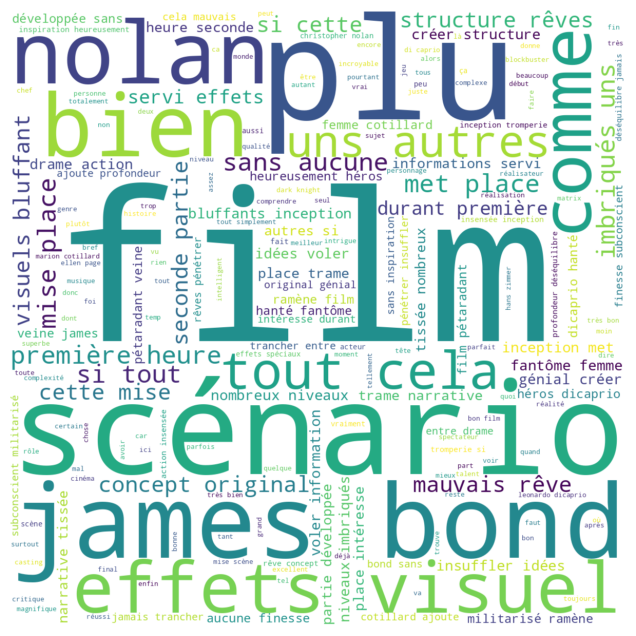

In [196]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud pour les avis négatif

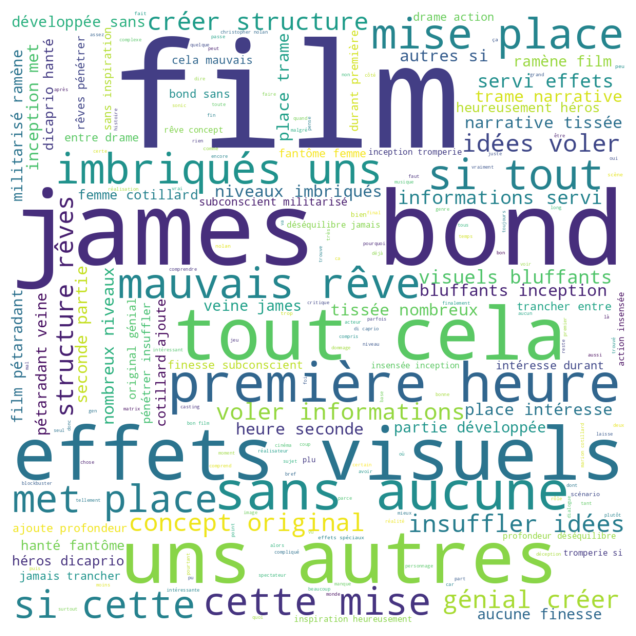

In [197]:
wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean[y_train == 0]))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud pour les avis positifs

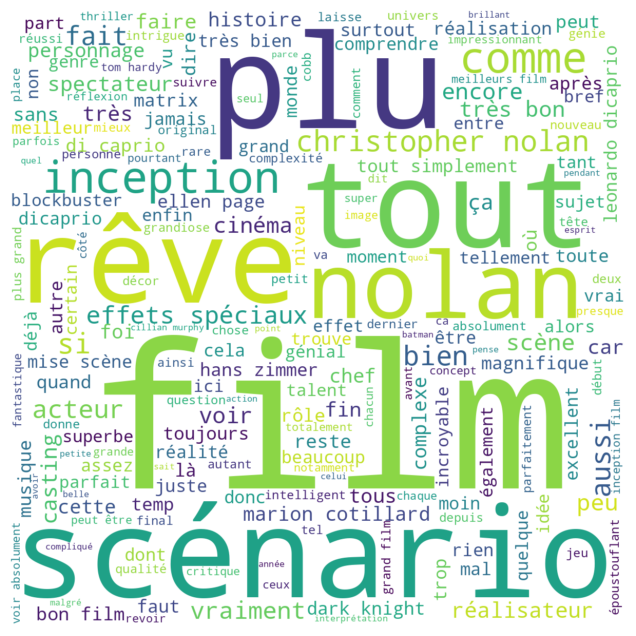

In [198]:
wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean[y_train == 1]))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Vectorisation des textes

#### Count Vectorizer

You should know that **Countvectorizer** has a few important parameters that you should adjust to your problem:

- **max_features**: build a vocabulary that only considers the top n tokens ordered by term frequency across the corpus.
- **min_df**: When building the vocabulary ignore terms that have a token frequency strictly lower than the given threshold
- **max_df**: When building the vocabulary ignore terms that have a token frequency strictly higher than the given threshold.

In [199]:
from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer(max_df=10,max_features=10000)
count_vectorizer = CountVectorizer(max_features=10000)
# X_train
X_train_vectors_counts = count_vectorizer.fit_transform(X_train_clean)
# X_test
X_test_vectors_counts = count_vectorizer.transform(X_test_clean)
X_train_vectors_counts.shape

(3704, 10000)

#### TF-IDF

One issue with Countvectorizer is that common words like “the” will appear many times (unless you remove them at the preprocessing stage) and these words are not actually important. One popular alternative is Tfidfvectorizer. It is an acronym for Term frequency-inverse document frequency.

- **Term Frequency**: This summarizes how often a given word appears within a document.
- **Inverse Document Frequency**: This downscales words that appear a lot across documents.

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)
X_train_tfidf.shape

(3704, 254883)

#### Word2Vec

The big issue with the above approaches is that the context of the word is lost when representing it. **Word embeddings** provide a much better representation of the words in NLP by encoding some context information. It provides a mapping from a word to a corresponding n-dimensional vector.

**Word2vec** is composed of two different models:

- **Continuous Bag of Words (CBOW)** model can be thought of as learning word embeddings by training a model to predict a word given its context.
- **Skip-Gram** model is the opposite, learning word embeddings by training a model to predict context given a word.

Some of the important parameters that you can actually change and observe the differences are:

- **size**: this indicates the embedding size of the resulting vector for each word.
- **min_count**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
- **window**: The number of words surrounding the word is considered when building the representation. Also known as the window size.

In [201]:
# import gensim
# from gensim.models import Word2Vec

# model = gensim.models.Word2Vec(corpus, min_count = 1, size = 100, window = 5)

## Sélection et entrainement du modèle

In [202]:
# Grid searching key hyperparameters for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_tfidf, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/david/workspace/py-sql/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/david/workspace/py-sql/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Best: 0.890298 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.890298 (0.017860) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.890208 (0.017831) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.890208 (0.017831) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.882467 (0.018751) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882467 (0.018751) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.882467 (0.018751) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.819471 (0.020100) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.819471 (0.020100) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.819741 (0.019992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.684213 (0.016511) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.684213 (0.016511) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.684393 (0.016539) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.683853 (0.016359) wit

**Logistic regression does not really have any critical hyperparameters to tune.**

Sometimes, you can see useful differences in performance or convergence with different **solvers (solver)**.

**solver** in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]

**Regularization (penalty)** can sometimes be helpful.

**penalty** in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]

Note: not all solvers support all regularization terms.

The **C parameter** controls the penality strength, which can also be effective.

**C** in [100, 10, 1.0, 0.1, 0.01]

In [210]:
model_best = grid_result.best_estimator_

## Analyse des résultats

Accuracy of LogisticRegression: 86.9220607661823 %


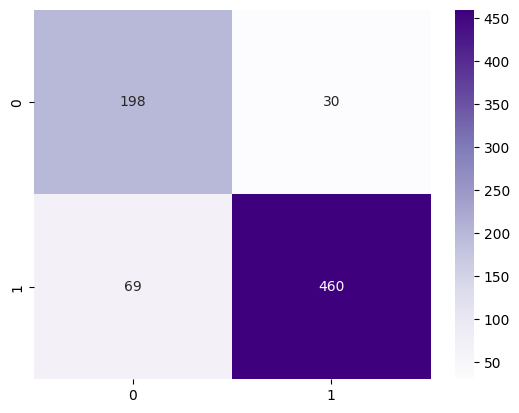

In [211]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_mb = model_best.predict(X_test_tfidf)
acc_mb = accuracy_score(y_pred_mb, y_test)
cm_mb = confusion_matrix(y_pred_mb, y_test)
sns.heatmap(cm_mb, annot=True, cmap='Purples', fmt='g')
print(f"Accuracy of {model_best.__class__.__name__}:", acc_mb*100,"%")

### Test avec un commentaire

In [212]:
bad_comment = "Ce film ne m'a pas plu du tout. Je l'ai trouvé sans interet. Le scenario est mauvais, les acteurs jouent mal."

# Nettoyer le commentaire
bad_comment_clean = clean_text(bad_comment)
print(bad_comment_clean)

film a plu tout trouvé sans interet scenario mauvais acteurs jouent mal


In [213]:
bad_comment_tfidf = tfidf.transform([bad_comment_clean])
bad_comment_tfidf.shape

(1, 254883)

In [214]:
pred = model_best.predict(bad_comment_tfidf)
pred

array([0.])

## Export du modèle

Exporter le modèle avec joblib ou Pickle. Il faut exporter :
- Le modèle (clf)
- La fonction de nettoyage (clean_text, dans un module)
- L'objet de vectorisation

In [215]:
import pickle

dict_export = {'model_best' : model_best, 'tfidf' : tfidf}

pickle_out = open("../flask-app/model.pkl","wb")
pickle.dump(dict_export, pickle_out)
pickle_out.close()